In [1]:
import os
import sys
import eli5
import shap
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    cross_val_predict
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.stats import lognorm, loguniform, randint
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve

In [2]:
#For Kendall Correlation
import scipy.stats as stats

In [3]:
#Plotly geberal graph franewoek
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as pyo

In [4]:
#To save ML sklearn objects
import pickle

## Loading Data, change encoding and Defining score metrics

In [5]:
# loading data from UCI ML Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, skiprows=1)

# renaming the target variable
df.rename(columns = {"default payment next month":"target"}, inplace=True)

# dropping ID
df.drop(columns='ID', inplace=True)

# Changing numeric encoding to labels
df['SEX'].replace([1, 2], ['Male', 'Female'],
                  inplace=True)

df['MARRIAGE'].replace([1, 2, 3, 0],
                       ['Married', 'Single', 'Other', 'Other'], inplace=True)

df['EDUCATION'].replace([1, 2, 3, 4, 0, 5, 6],
                        ['GraduateSchool', 'University', 'HighSchool', 'Other',
                         'Other', 'Other', 'Other'], inplace=True)

In [6]:
# split the data 80/20

train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)
train_df.shape

(24000, 24)

In [7]:
print(
    "Distribution of the target variable - train data:\n",
    train_df["target"].value_counts(normalize=True), sep=''
)
print(
    "Distribution of the target variable - all data:\n",
    df["target"].value_counts(normalize=True), sep=''
)

Distribution of the target variable - train data:
0    0.779125
1    0.220875
Name: target, dtype: float64
Distribution of the target variable - all data:
0    0.7788
1    0.2212
Name: target, dtype: float64


Class imbalance in the target variable.

In [8]:
# Separate X and Y for training and testing 
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [ ]:
"""
tmp_array =  np.array([np.random.binomial(1, 0.5, size=1000),np.random.binomial(1, 0.5, size=1000)])
tmp_df = pd.DataFrame(tmp_array.T, columns = ['true','pred'])
tmp_df['n'] = 1
tmp_df_g = tmp_df.groupby(['true','pred'],as_index=False).sum('n')
#earnings = alpha*true_negative - (1-alpha)*false_negative
alpha = 1/3
cond1 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 1)
cond2 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 0)
cond3 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 0)
cond4 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 1)
true_positive = tmp_df_g.loc[cond1]['n'].iloc[0]
false_negative = tmp_df_g.loc[cond2]['n'].iloc[0]
true_negative = tmp_df_g.loc[cond3]['n'].iloc[0]
false_positive = tmp_df_g.loc[cond4]['n'].iloc[0]
earnings = alpha*true_negative - (1-alpha)*false_negative
earnings
"""

In [9]:
#Custom scorer for scikit-learn, resources:
    #https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions
    #https://stackoverflow.com/questions/32401493/how-to-create-customize-your-own-scorer-function-in-scikit-learn
def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return np.log1p(diff)
#Banks earnings:
def bank_earnings_f(y_true, y_pred):
    tmp_array =  np.array([np.random.binomial(1, 0.5, size=1000),np.random.binomial(1, 0.5, size=1000)])
    tmp_df = pd.DataFrame(tmp_array.T, columns = ['true','pred'])
    tmp_df['n'] = 1
    tmp_df_g = tmp_df.groupby(['true','pred'],as_index=False).sum('n')
    #earnings = alpha*true_negative - (1-alpha)*false_negative
    alpha = 1/3
    cond1 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 1)
    cond2 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 0)
    cond3 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 0)
    cond4 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 1)
    true_positive = tmp_df_g.loc[cond1]['n'].iloc[0]
    false_negative = tmp_df_g.loc[cond2]['n'].iloc[0]
    true_negative = tmp_df_g.loc[cond3]['n'].iloc[0]
    false_positive = tmp_df_g.loc[cond4]['n'].iloc[0]
    earnings = alpha*true_negative - (1-alpha)*false_negative
    return earnings

bank_earnings = make_scorer(bank_earnings_f, greater_is_better=True)

In [10]:
# evalution metric for scoring
f1_micro = make_scorer(f1_score, average="micro")

scoring = {
    "earnings": bank_earnings,
    "f1": f1_micro,
    "recall": "recall",
    "precision": "precision",
    'roc_auc': 'roc_auc'
}

## Exploratory Data Analysis

In [11]:
#Compare kendall vs. pearson correlation
#Kendall
l = list(df.columns)
l = len(l)
corr_k = np.zeros([l,l])
corr_k = np.asmatrix(corr_k)
for c1 in range(l):
    for c2 in range(l):
        tau, p_value = stats.kendalltau(df.iloc[:,c1],df.iloc[:,c2])
        tau = round(tau,3)
        corr_k[c1,c2] = tau
        
corr_k = pd.DataFrame(corr_k)
corr_k.columns = df.columns
corr_k.index = df.columns
corr_k = corr_k.round(2)
#Pearson
corr = df.corr().round(decimals=2)

In [12]:
fig1 = px.imshow(corr_k.T, color_continuous_scale='viridis', origin='lower')
fig2 = px.imshow(corr.T, color_continuous_scale='viridis', origin='lower')
fig1 = fig1.update_layout(title='Matrix correlation - Kendall',height=700)
fig2 = fig2.update_layout(height=700,title='Matrix correlation - Pearson')

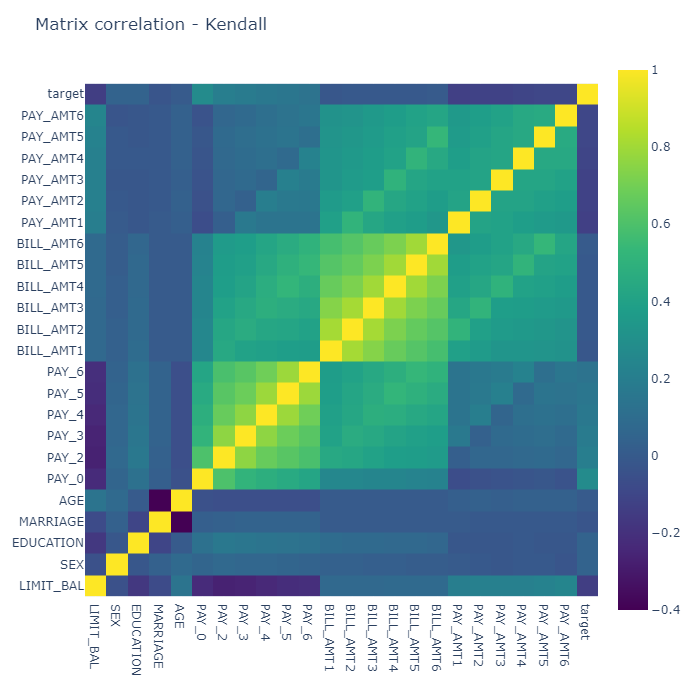

In [14]:
#pyo.iplot(fig1, filename = 'fig1')
fig1.show("png")

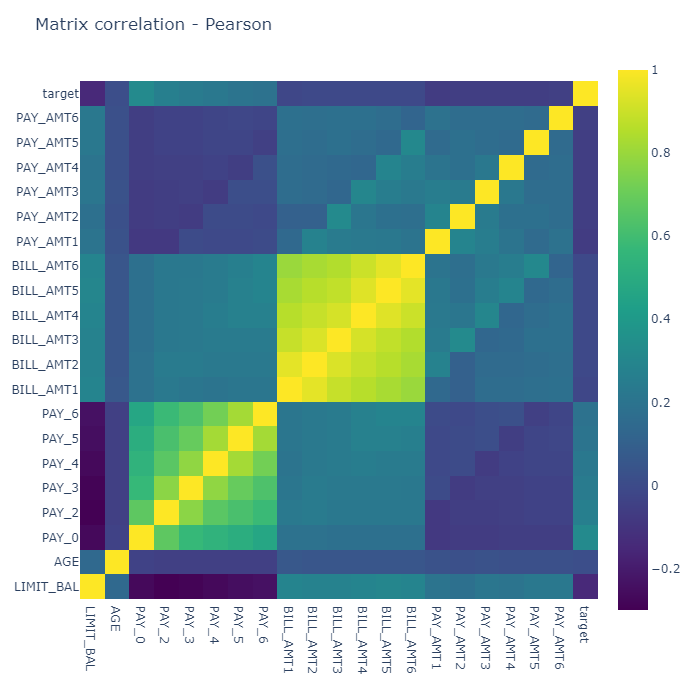

In [15]:
#pyo.iplot(fig2, filename = 'fig2')
fig2.show("png")

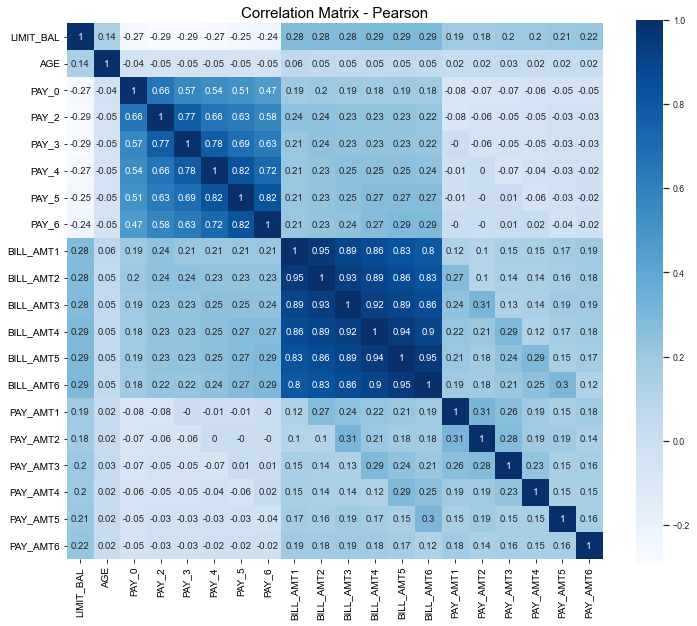

In [50]:
f, ax = plt.subplots(figsize=(12, 10))
corr = train_df.drop(columns=["target"]).corr().round(decimals=2)
sns.set(font_scale=0.8)
sns.heatmap(corr, cmap='Blues',
            square=True, ax=ax, annot=True)
plt.title('Correlation Matrix - Pearson', fontsize=15)
plt.show();

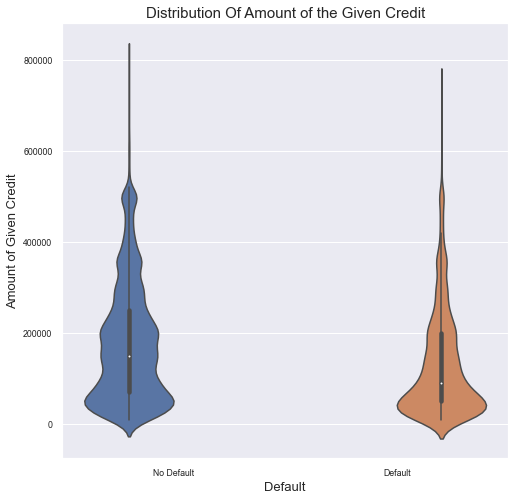

In [51]:
f, ax = plt.subplots(figsize=(8, 8))
violin= sns.violinplot(x="target",
                       y="LIMIT_BAL",
                       hue='target',
               data=train_df)
plt.title('Distribution Of Amount of the Given Credit', fontsize=15)
plt.legend().remove()
plt.xlabel('Default', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'No Default'
labels[1] = 'Default'
ax.set_xticklabels(labels)
plt.show();

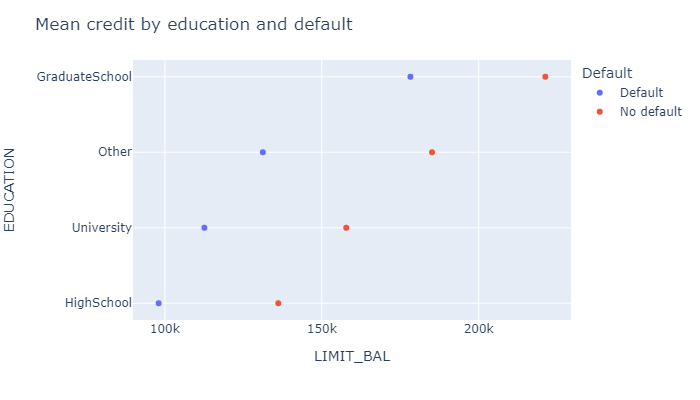

In [16]:
#Mean credit by education and default
tmp = df.loc[:,['LIMIT_BAL','EDUCATION', 'target']].groupby(['target','EDUCATION'],as_index=False).mean('LIMIT_BAL')
cond1 = tmp['target'] == 0
cond2 = tmp['target'] >0
column_name = 'Default'
tmp.loc[cond1, column_name] = 'No default'
tmp.loc[cond2, column_name] = 'Default'
tmp = tmp.sort_values(by = 'LIMIT_BAL',ascending=True)

fig3 = px.scatter(tmp, x="LIMIT_BAL", y="EDUCATION", color="Default")
fig3 = fig3.update_layout(width =700, height=400,title='Mean credit by education and default')

#pyo.iplot(fig3, filename = 'fig3')
fig3.show("png")
#https://plotly.com/python/styling-plotly-express/

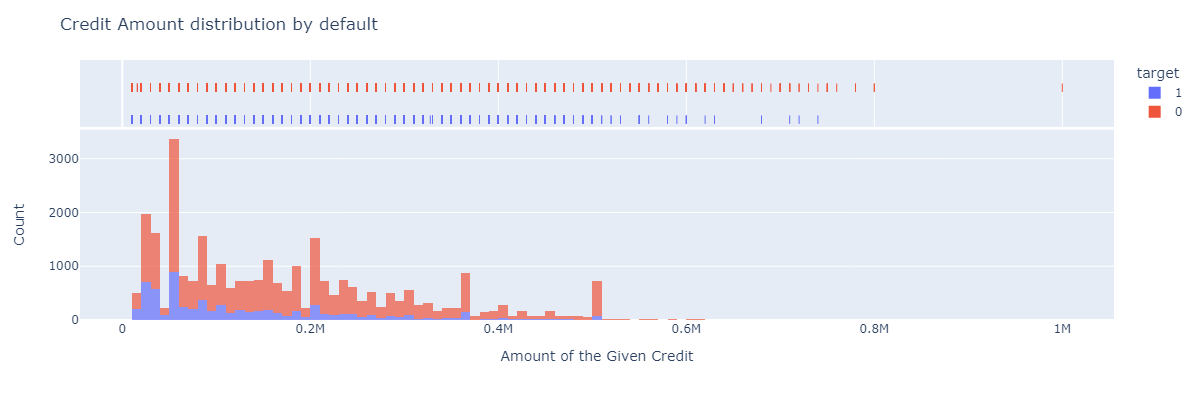

In [26]:
fig4 = px.histogram(df, x="LIMIT_BAL", color="target", marginal="rug", 
                   hover_data=df.columns, nbins=100,
                   opacity=0.7)

fig4 = fig4.update_layout(xaxis_title_text = 'Amount of the Given Credit',
                          yaxis_title_text = 'Count', 
                          title = 'Credit Amount distribution by default',
                          height = 400, width = 1200)

#pyo.iplot(fig4, filename = 'fig4')
fig4.show("png")

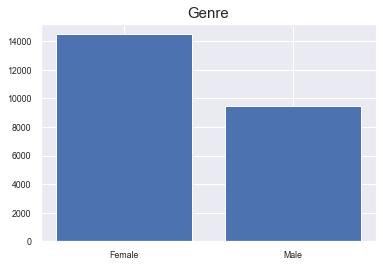

In [107]:
plt.bar(train_df['SEX'].unique().tolist(),
       train_df['SEX'].value_counts().tolist())
plt.title('Genre', fontsize=15);

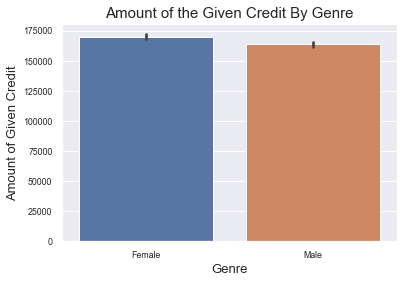

In [108]:
sns.barplot(x = 'SEX',y='LIMIT_BAL',data = df)
plt.xlabel('Genre', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)
plt.title('Amount of the Given Credit By Genre', fontsize=15)
plt.show();

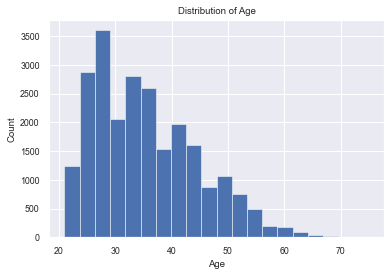

In [109]:
fig, ax = plt.subplots()
ax.hist(train_df['AGE'], bins=20, linewidth=0.5, edgecolor="white")
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show();

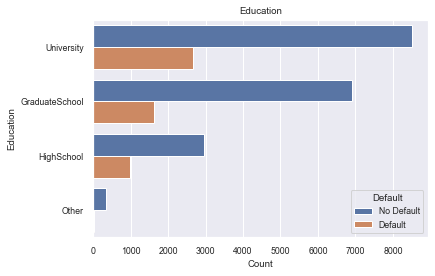

In [110]:
fig, ax = plt.subplots()
ax = sns.countplot(y="EDUCATION", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('Education')
plt.title('Education')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

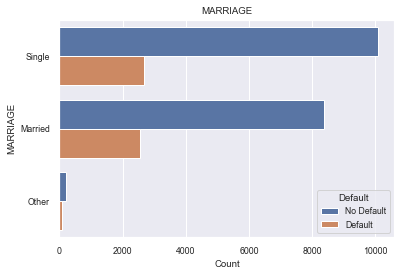

In [111]:
fig, ax = plt.subplots()
ax = sns.countplot(y="MARRIAGE", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('MARRIAGE')
plt.title('MARRIAGE')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

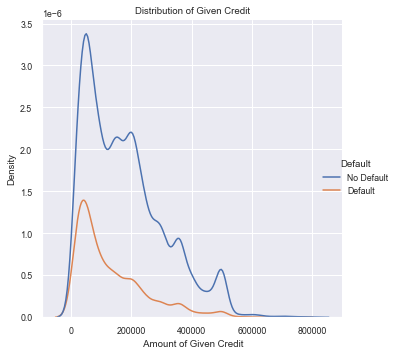

In [112]:
ax = sns.displot(x="LIMIT_BAL", hue="target", data=train_df, kind="kde")
ax.set(xlabel=' Amount of Given Credit', title='Distribution of Given Credit')
ax._legend.set_title('Default')
new_labels = ['No Default', 'Default']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
sns.move_legend(ax, "center right")

In [8]:
# Preprocessing and transformations

numeric_features = ["LIMIT_BAL", "AGE",
                    "PAY_0", "PAY_2",
                    "PAY_3", "PAY_4",
                    "PAY_5", "PAY_6",
                    'BILL_AMT1', 'BILL_AMT2',
                    'BILL_AMT3', 'BILL_AMT4',
                    'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2',
                    'PAY_AMT3', 'PAY_AMT4',
                    'PAY_AMT5', 'PAY_AMT6']

categorical_features = ["MARRIAGE"]

binary_features = ["SEX"]

ordinal_features = ["EDUCATION"]

education_levels = ['Other',  'HighSchool', 'University', 'GraduateSchool']


# preprocessor

preprocessor = make_column_transformer(

    (StandardScaler(), numeric_features),

    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features
    ),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        categorical_features
    )

)

In [9]:
## Code attribution: UBC-MDS DSCI-571 Varada Kolhatkar 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, cv = 10, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## Modelling 

In [115]:
# Dictionary of Results

results = {}

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVC": SVC(random_state=123),
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123, eval_metric="logloss",
                             verbosity=0, use_label_encoder=False,
                             class_weight="balanced"),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0,
                                   random_state=123)
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )

pd.DataFrame(results).T

,fit_time,score_time,test_earnings,train_earnings,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Logistic Regression,0.222 (+/- 0.012),0.016 (+/- 0.006),-83.600 (+/- 9.122),-81.900 (+/- 11.813),0.810 (+/- 0.006),0.811 (+/- 0.001),0.234 (+/- 0.013),0.236 (+/- 0.006),0.720 (+/- 0.048),0.720 (+/- 0.003),0.721 (+/- 0.011),0.723 (+/- 0.002)
SVC,15.946 (+/- 0.403),4.074 (+/- 0.025),-84.333 (+/- 17.158),-78.600 (+/- 9.713),0.819 (+/- 0.006),0.824 (+/- 0.001),0.321 (+/- 0.019),0.335 (+/- 0.006),0.695 (+/- 0.033),0.717 (+/- 0.006),0.720 (+/- 0.011),0.778 (+/- 0.002)
Random Forest,4.807 (+/- 0.028),0.114 (+/- 0.003),-87.567 (+/- 9.406),-80.967 (+/- 15.045),0.816 (+/- 0.006),1.000 (+/- 0.000),0.363 (+/- 0.017),0.998 (+/- 0.000),0.651 (+/- 0.026),0.999 (+/- 0.000),0.760 (+/- 0.017),1.000 (+/- 0.000)
XGBoost,0.838 (+/- 0.312),0.030 (+/- 0.004),-84.333 (+/- 9.746),-89.133 (+/- 9.088),0.814 (+/- 0.006),0.887 (+/- 0.002),0.356 (+/- 0.009),0.560 (+/- 0.009),0.644 (+/- 0.031),0.890 (+/- 0.006),0.762 (+/- 0.014),0.945 (+/- 0.004)
LightGBM,0.170 (+/- 0.009),0.027 (+/- 0.004),-82.333 (+/- 9.730),-79.233 (+/- 10.926),0.820 (+/- 0.006),0.845 (+/- 0.002),0.361 (+/- 0.015),0.422 (+/- 0.006),0.675 (+/- 0.031),0.772 (+/- 0.006),0.777 (+/- 0.013),0.886 (+/- 0.002)
CatBoost,6.008 (+/- 0.121),0.046 (+/- 0.009),-85.367 (+/- 10.101),-81.867 (+/- 10.553),0.819 (+/- 0.007),0.856 (+/- 0.001),0.359 (+/- 0.016),0.458 (+/- 0.006),0.667 (+/- 0.031),0.806 (+/- 0.003),0.778 (+/- 0.015),0.892 (+/- 0.001)


In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
result = loaded_model.score(X_train, y_train)
print(result)

print("Best score: %0.3f" % (loaded_model.best_score_))

print("Best hyperparameter values: ", loaded_model.best_params_)

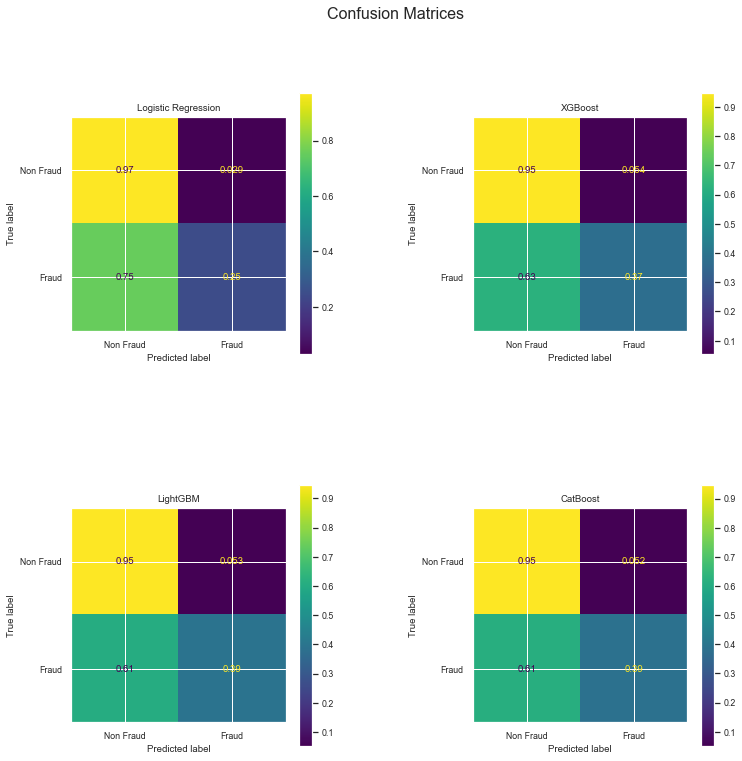

In [18]:
# Building Confusion Matrix

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                                             figsize=(12, 12))

fig.subplots_adjust(wspace = 0.5, hspace = 0.5 )

fig.suptitle("Confusion Matrices", horizontalalignment='center',
             fontsize=16)

axes = [ax1, None, None, ax2, ax3, ax4 ]
labels = ["Non Fraud", "Fraud"]

for (k, m), ax in zip(models.items(), axes):

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    ConfusionMatrixDisplay.from_estimator(

        pipe, X_test, y_test, ax=ax, display_labels=labels,
        normalize='true'
    )
    ax.set_title(f"{k}")

fig;

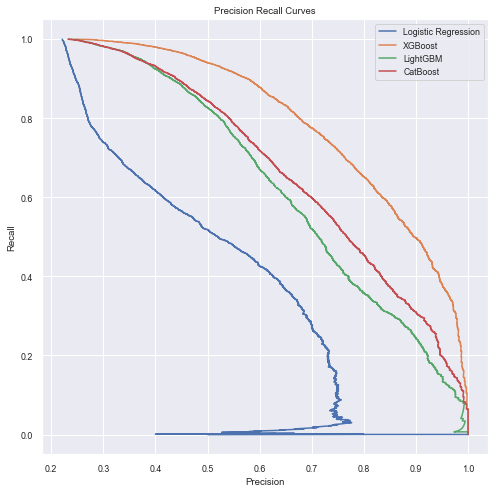

In [19]:
f, ax = plt.subplots(figsize=(8, 8))

for k, m in models.items():

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    precision, recall, thresholds = precision_recall_curve(
        y_train, pipe.predict_proba(X_train)[:, 1])

    plt.plot(precision, recall, label=k)

plt.title("Precision Recall Curves")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best");

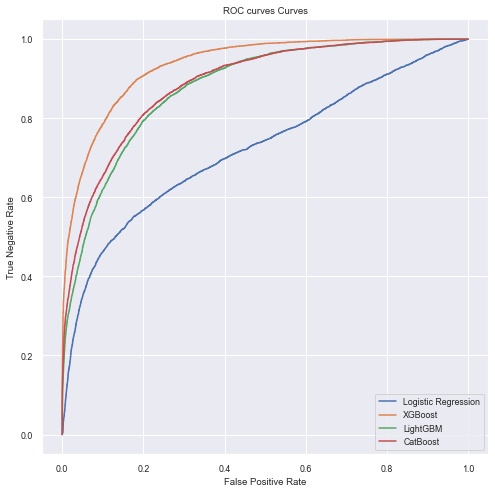

In [20]:
f, ax = plt.subplots(figsize=(8, 8))

for k, m in models.items():

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    precision, recall, thresholds = roc_curve(
        y_train, pipe.predict_proba(X_train)[:, 1])

    plt.plot(precision, recall, label=k)

plt.title("ROC curves Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend(loc="best");

## Class Balancing - SMOTE 

In [ ]:
results_smote = {}
for name, model in models.items():
    pipe = make_imb_pipeline(preprocessor,
                             SMOTE(),
                             model)
    results_smote[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )

pd.DataFrame(results_smote).T

## Hyperparameter Tunning LGBM

In [22]:
# Light GBM
pipe_lgbm = make_imb_pipeline(preprocessor, LGBMClassifier(random_state=123))

params = {
    "lgbmclassifier__boosting_type": ['gbdt', 'dart'],
    "lgbmclassifier__num_leaves ": randint(low=10, high=2000),
    "lgbmclassifier__n_estimators":randint(low=10, high=2000),
    "lgbmclassifier__class_weight": [None, "balanced"]
}

search = RandomizedSearchCV(
    pipe_lgbm,
    params,
    verbose=0,
    n_jobs=-1,
    n_iter=50,
    return_train_score=True,
    scoring= f1_micro,
    random_state=123,
)

search.fit(X_train, y_train);

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 960


In [23]:
print("Best score: %0.3f" % (search.best_score_))

print("Best hyperparameter values: ", search.best_params_)

Best score: 0.821
Best hyperparameter values:  {'lgbmclassifier__boosting_type': 'dart', 'lgbmclassifier__class_weight': None, 'lgbmclassifier__n_estimators': 369, 'lgbmclassifier__num_leaves ': 960}


In [24]:
b_type = search.best_params_['lgbmclassifier__boosting_type']
n_estimators= search.best_params_['lgbmclassifier__n_estimators']
num_leaves= search.best_params_['lgbmclassifier__num_leaves ']

In [25]:
pipe_lgbm_best = make_imb_pipeline(preprocessor,
                                   LGBMClassifier(random_state=123,
                                                  boosting_type=b_type,
                                                  n_estimators= n_estimators,
                                                  num_leaves= num_leaves))
pipe_lgbm_best.fit(X_train, y_train);

### Results

In [26]:
print(
    f"Grid Search best model validation score: {round(search.best_score_, 3)}"
)


print(f"Test f1 score:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")

Grid Search best model validation score: 0.821
Test f1 score:  0.814


In [27]:
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")

Test f1 score - micro-average:  0.814
Test Accuracy score: 0.814
Test Recall score: 0.394
Test ROC_AUC score: 0.664
Test precision score: 0.631


In [28]:
binary_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()

In [29]:
categorical_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()

In [30]:
feature_names = numeric_features + ordinal_features + binary_names + categorical_names

In [31]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)


X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


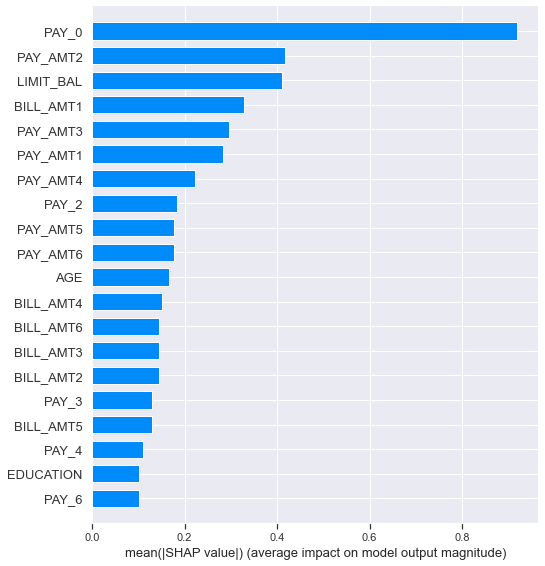

In [32]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

## Hyperparameter Tunning LGBM - custom loss function

In [10]:
# Light GBM
pipe_lgbm = make_imb_pipeline(preprocessor, LGBMClassifier(random_state=123))

params = {
    "lgbmclassifier__boosting_type": ['gbdt', 'dart'],
    "lgbmclassifier__num_leaves ": randint(low=10, high=2000),
    "lgbmclassifier__n_estimators":randint(low=10, high=2000),
    "lgbmclassifier__class_weight": [None, "balanced"]
}

search = RandomizedSearchCV(
    pipe_lgbm,
    params,
    verbose=0,
    n_jobs=-1,
    n_iter=50,
    return_train_score=True,
    scoring= bank_earnings,
    random_state=123,
)

search.fit(X_train, y_train);

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 1851


In [15]:
# save the model to disk
filename = 'LightGBM_50i_cfEarningsAlpha05.sav'
pickle.dump(search, open(filename, 'wb'))

In [26]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
result = loaded_model.score(X_train, y_train)
print(result)

print("Best score: %0.3f" % (loaded_model.best_score_))

print("Best hyperparameter values: ", loaded_model.best_params_)

-80.33333333333336
-95.00000000000001
Best score: -74.600
Best hyperparameter values:  {'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__class_weight': None, 'lgbmclassifier__n_estimators': 1102, 'lgbmclassifier__num_leaves ': 1851}


In [28]:
print("Best score: %0.3f" % (search.best_score_))

print("Best hyperparameter values: ", search.best_params_)

Best score: -74.600
Best hyperparameter values:  {'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__class_weight': None, 'lgbmclassifier__n_estimators': 1102, 'lgbmclassifier__num_leaves ': 1851}


In [29]:
b_type = search.best_params_['lgbmclassifier__boosting_type']
n_estimators= search.best_params_['lgbmclassifier__n_estimators']
num_leaves= search.best_params_['lgbmclassifier__num_leaves ']

In [30]:
pipe_lgbm_best = make_imb_pipeline(preprocessor,
                                   LGBMClassifier(random_state=123,
                                                  boosting_type=b_type,
                                                  n_estimators= n_estimators,
                                                  num_leaves= num_leaves))
pipe_lgbm_best.fit(X_train, y_train);

### Results

In [31]:
print(
    f"Grid Search best model validation score: {round(search.best_score_, 3)}"
)


print(f"Test f1 score:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")

Grid Search best model validation score: -74.6
Test f1 score:  0.812


In [32]:
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")

Test f1 score - micro-average:  0.812
Test Accuracy score: 0.812
Test Recall score: 0.401
Test ROC_AUC score: 0.665
Test precision score: 0.62


In [33]:
binary_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()

In [34]:
categorical_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()

In [35]:
feature_names = numeric_features + ordinal_features + binary_names + categorical_names

In [ ]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)


X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

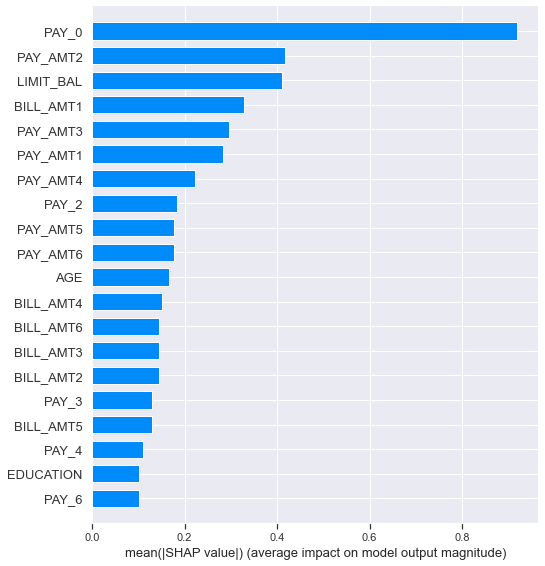

In [32]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")